# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

In [ ]:
# def download_file(url, file_path):
#     import requests
#     r = requests.get(url)
#     with open(file_path, 'wb') as f:
#         f.write(r.content)

# def load_dataset(file_path, fraction=1.0):
#     with open(file_path, 'r', encoding='utf-8') as f:
#         raw_text = f.read()
#     return raw_text[:int(fraction * len(raw_text))]

# dataset = 'downloaded_books/mark_twain.txt' # Other options are mark_twain.txt, charles_dickens.txt

# download_file(f'https://github.com/UofT-DSI/deep_learning/raw/main/assignments/downloaded_books/' + dataset, dataset)

# # Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
# text = load_dataset(dataset, fraction=0.1)

In [44]:
dataset = 'downloaded_books/mark_twain.txt'

fraction = 0.1
with open(dataset, 'r', encoding='utf-8') as file:
    raw_text = file.read()
text = raw_text[:int(fraction * len(raw_text))]

#text

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [24]:
# Your code here
#Print the first 1000 characters
print(text[:1000])




The Project Gutenberg EBook of The Prince and The Pauper, Complete by
Mark Twain (Samuel Clemens)

This eBook is for the use of anyone anywhere at no cost and with almost
no restrictions whatsoever. You may copy it, give it away or re-use
it under the terms of the Project Gutenberg License included with this
eBook or online at www.gutenberg.org

Title: The Prince and The Pauper, Complete

Author: Mark Twain (Samuel Clemens)

Release Date: August 20, 2006 [EBook #1837]
Last Updated: February 19, 2018

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK PRINCE AND THE PAUPER ***

Produced by David Widger. The earliest PG edition was prepared by Les
Bowler




THE PRINCE AND THE PAUPER

by Mark Twain

The Great Seal

I will set down a tale as it was told to me by one who had it of his
father, which latter had it of HIS father, this last having in like
manner had it of HIS father--and so on, back and still back, three
hundred years and more, the fat

In [25]:
#Report dataset size and number of unique characters
dataset_size = len(text)
unique_chars = len(set(text))

print(f"Dataset size: {dataset_size} characters")
print(f"Number of unique characters: {unique_chars}")

Dataset size: 1267477 characters
Number of unique characters: 90


## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [ ]:


# Your code here
VOCAB_SIZE = 4000
OOV_TOKEN = '<OOV>'

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts([text])

print(text[:1000])
print(f"Vocabulary size: {VOCAB_SIZE}")



The Project Gutenberg EBook of The Prince and The Pauper, Complete by
Mark Twain (Samuel Clemens)

This eBook is for the use of anyone anywhere at no cost and with almost
no restrictions whatsoever. You may copy it, give it away or re-use
it under the terms of the Project Gutenberg License included with this
eBook or online at www.gutenberg.org

Title: The Prince and The Pauper, Complete

Author: Mark Twain (Samuel Clemens)

Release Date: August 20, 2006 [EBook #1837]
Last Updated: February 19, 2018

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK PRINCE AND THE PAUPER ***

Produced by David Widger. The earliest PG edition was prepared by Les
Bowler




THE PRINCE AND THE PAUPER

by Mark Twain

The Great Seal

I will set down a tale as it was told to me by one who had it of his
father, which latter had it of HIS father, this last having in like
manner had it of HIS father--and so on, back and still back, three
hundred years and more, the fat

If everything worked, the following line should show you the first 10 words in the vocabulary:

In [27]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('in', 7), ('was', 8), ('he', 9), ('it', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [30]:
SEQ_LENGTH = 50 # Choose an appropriate sequence length

# Convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0] 
print(f"Total number of tokens: {len(sequences)}")
# Generate the training sequences
X = []
y = []
# Your code here

for i in range(SEQ_LENGTH, len(sequences)):
    X.append(sequences[i-SEQ_LENGTH:i])
    y.append(sequences[i])

# Convert to numpy arrays
if X and y:
    X = np.array(X)
    y = np.array(y)

    print(f"Number of training sequences: {len(X)}")
    print(f"First training sequence: {X[0]}")
    print(f"First target value: {y[0]}")
else:
    print("No training sequences generated. Check the size of the dataset or SEQ_LENGTH.")

Total number of tokens: 231759
Number of training sequences: 231709
First training sequence: [   2  163  151  929    4    2   84    3    2  627 1216   24  582  776
 2261 2747   22  929   20   16    2  327    4 1866 1443   23   46  826
    3   14  318   46 3108 2513   28  154  930   10  248   10   86   36
 2514  327   10  157    2  518    4    2]
First target value: 163


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [31]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [   2  163  151  929    4    2   84    3    2  627 1216   24  582  776
 2261 2747   22  929   20   16    2  327    4 1866 1443   23   46  826
    3   14  318   46 3108 2513   28  154  930   10  248   10   86   36
 2514  327   10  157    2  518    4    2]
Target: 163
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'prince', 'and', 'the', 'pauper', 'complete', 'by', 'mark', 'twain', 'samuel', 'clemens', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms', 'of', 'the'] -> project


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [32]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (167985, 50)
y_train shape: (167985, 4000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [33]:

embedding_dim = 64

model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=embedding_dim, input_length=SEQ_LENGTH))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dense(units=VOCAB_SIZE, activation='softmax'))

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

In [39]:
# Your code here
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, SEQ_LENGTH))  
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 64)         │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4000)           │       404,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 726,000 (2.77 MB)

 Trainable params: 726,000 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
output = model.predict(X_train[:1])
print(f"Model output shape: {output.shape}")
print(f"Expected y shape: {y_train[:1].shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Model output shape: (1, 4000)
Expected y shape: (1, 4000)


## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [41]:
# Your code here
epochs = 5
batch_size = 128

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (167985, 50)
y_train shape: (167985, 4000)
X_val shape: (41997, 50)
y_val shape: (41997, 4000)


In [42]:
# Check for NaN or Inf values in the datasets
print(f"Check NaN in X_train: {np.isnan(X_train).any()}")
print(f"Check NaN in y_train: {np.isnan(y_train).any()}")
print(f"Check Inf in X_train: {np.isinf(X_train).any()}")
print(f"Check Inf in y_train: {np.isinf(y_train).any()}")

Check NaN in X_train: False
Check NaN in y_train: False
Check Inf in X_train: False
Check Inf in y_train: False


In [43]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

Epoch 1/5
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 71s 53ms/step - accuracy: 0.0655 - loss: 6.4777 - val_accuracy: 0.1000 - val_loss: 5.9410
Epoch 2/5
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 73s 56ms/step - accuracy: 0.1082 - loss: 5.8256 - val_accuracy: 0.1189 - val_loss: 5.6856
Epoch 3/5
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 72s 55ms/step - accuracy: 0.1242 - loss: 5.5421 - val_accuracy: 0.1277 - val_loss: 5.5091
Epoch 4/5
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 73s 56ms/step - accuracy: 0.1362 - loss: 5.3376 - val_accuracy: 0.1369 - val_loss: 5.3823
Epoch 5/5
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 73s 55ms/step - accuracy: 0.1473 - loss: 5.1488 - val_accuracy: 0.1451 - val_loss: 5.2901
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1462 - loss: 5.2750
Validation Loss: 5.290093421936035
Validation Accuracy: 0.14512941241264343


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

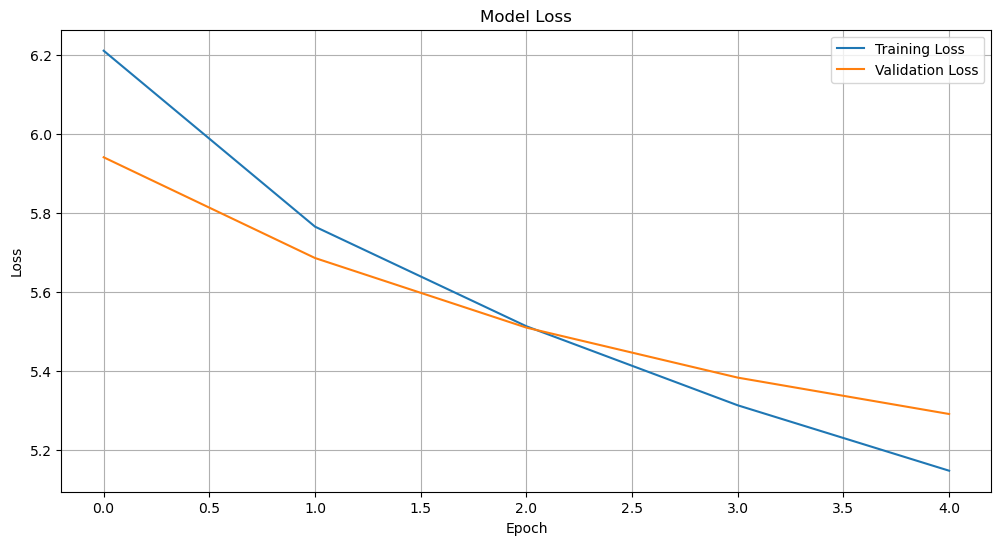

In [44]:
import matplotlib.pyplot as plt

# Your code here
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [55]:
from keras.preprocessing.sequence import pad_sequences

# Define the get_predicted_word function
def get_predicted_word(model, sequence):
    yhat = model.predict(sequence, verbose=0)
    yhat = np.random.choice(range(yhat.shape[1]), p=yhat.ravel())
    return yhat

# Define the generate_text function
def generate_text(model, tokenizer, seed_text, max_sequence_len, num_words_to_generate=50):
    # Tokenize the seed text
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Initialize the generated text with the seed text
    generated_text = seed_text
    
    for _ in range(num_words_to_generate):
        # Pad the token list to the max sequence length
        token_list_padded = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
        
        # Predict the next word
        predicted_token = get_predicted_word(model, token_list_padded)
        
        # Add the predicted token to the token list
        token_list.append(predicted_token)
        
        # Remove the first token to maintain the sequence length
        token_list = token_list[1:]
        
        # Convert the predicted token to a word and append to the generated text
        predicted_word = tokenizer.index_word.get(predicted_token, '')
        generated_text += ' ' + predicted_word
    
    return generated_text



In [56]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet lay do at to to these a merciful welcome to him rich protector ” not they a tax who the his hang be the your is my ” ” to so service that worth and indeed shall for it did by ever several protector and not the it and my'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small. 

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras. 
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [ ]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip


--2024-11-28 10:00:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.03MB/s    in 2m 39s  

2024-11-28 10:02:42 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [60]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [61]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [62]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [63]:
embedding_dim = 100

# Prepare embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [64]:
# Define a new model and train it

# Your code here
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

# Define a new model with pre-trained embeddings
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, 
                    output_dim=embedding_dim, 
                    input_length=SEQ_LENGTH, 
                    weights=[embedding_matrix], 
                    trainable=False))
model.add(LSTM(units=150, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=VOCAB_SIZE, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Fit the model
epochs = 20  # Training for more epochs
batch_size = 256  # Experimenting with larger batch size

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │       400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,000 (1.53 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 400,000 (1.53 MB)

Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 141s 213ms/step - accuracy: 0.0590 - loss: 6.6400 - val_accuracy: 0.0775 - val_loss: 6.2086
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 140s 213ms/step - accuracy: 0.0797 - loss: 6.1529 - val_accuracy: 0.0917 - val_loss: 5.9727
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 136s 208ms/step - accuracy: 0.0924 - loss: 5.9421 - val_accuracy: 0.0990 - val_loss: 5.8337
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 192s 293ms/step - accuracy: 0.0961 - loss: 5.8153 - val_accuracy: 0.1029 - val_loss: 5.7221
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 137s 208ms/step - accuracy: 0.1022 - loss: 5.6948 - val_accuracy: 0.1120 - val_loss: 5.6231
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 137s 208ms/step - accuracy: 0.1081 - loss: 5.5768 - val_accuracy: 0.1145 - val_loss: 5.5511
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 136s 207ms/step - accuracy: 0.1109 - loss: 5.5114 - val_accuracy: 0.1202 - val_loss: 5.4822
Epoch 8/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 136s 207ms/step - accuracy: 0.1141 -

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.1401 - loss: 5.1407
Validation Loss: 5.1504740715026855
Validation Accuracy: 0.1394861489534378


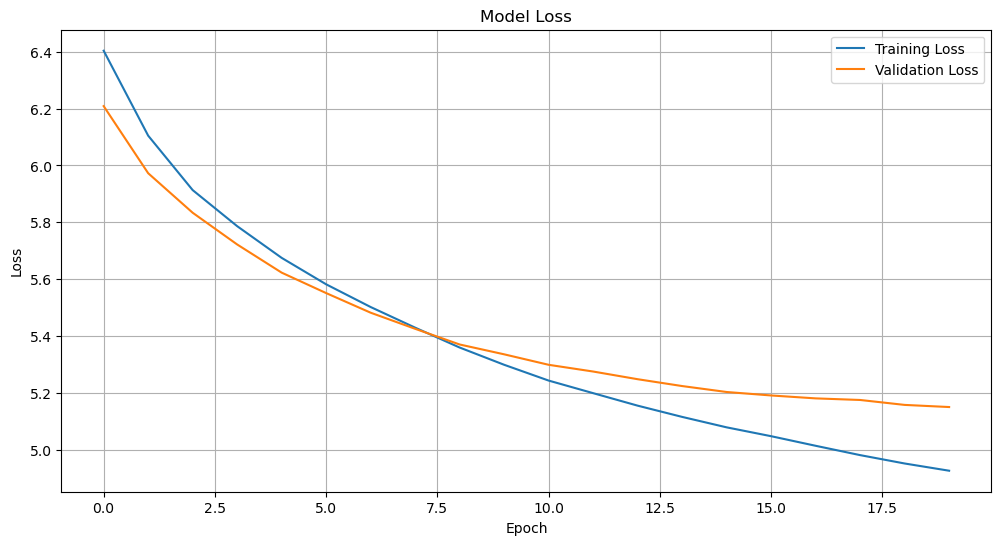

In [65]:
# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()




In [66]:
# Generate and print new text
seed_text = "Once upon a time"
max_sequence_len = SEQ_LENGTH
generated_text = generate_text(model, tokenizer, seed_text, max_sequence_len, num_words_to_generate=50)
print(generated_text)

Once upon a time and upon the time chapter sent his comrades tom and week to himself and plunged his clothing with the palace after some the floor burst there came himself with his robes only asked his servant chapter xi tom are all wallow and toure disposed and the street curiously gazing in


## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.